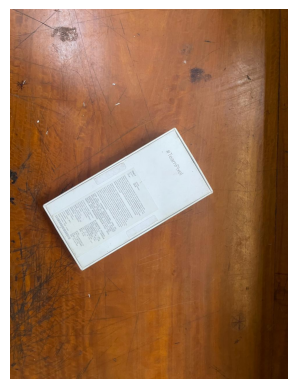

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read the image
img1 = cv2.imread("img1.jpg")
img2 = cv2.imread("img2.jpg")
img3 = cv2.imread("img3.jpg")

# convert BGR to RGB
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

img = img3_rgb

# show img1 using matplotlib
plt.imshow(img)
plt.axis('off')  # optional: to hide the axis
plt.show()


In [2]:
from utils import (
    get_box_coordinates,
    get_image_with_box_corners,
    get_model,
)


In [3]:
model_name = "fastSAM-s"
device = "cpu"
fast_sam_s_checkpoint = "FastSAM-s.pt"

In [4]:
import config

In [5]:

def get_model(model_name: str):
    if model_name == "fastSAM":
        from fastsam import FastSAM

        model_fast_sam = FastSAM(config.fast_sam_checkpoint)
        return model_fast_sam

    elif model_name == "fastSAM-s":
        from fastsam import FastSAM

        model_fast_sam_s = FastSAM(config.fast_sam_s_checkpoint)
        return model_fast_sam_s

    elif model_name == "SAM":
        pass

    else:
        pass

model = get_model(model_name)

## Functions 

In [6]:
# get image dimensions
img_height, img_width, _ = img.shape

In [7]:
# get centre point coordinates
center_point_coords = [int(img_width / 2), int(img_height / 2)]
input_point = np.array([center_point_coords])
input_label = np.array([1])

In [8]:
input_label

array([1])

In [9]:
type(model)

fastsam.model.FastSAM

In [10]:
model.model

SegmentationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
 

### Everything Prompt

In [11]:
from fastsam import FastSAMPrompt

fast_sam_predictor = model(img, device=device, retina_masks=True, imgsz=img_width, conf=0.4, iou=0.9,)
fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)


0: 960x736 11 objects, 1540.7ms
Speed: 30.4ms preprocess, 1540.7ms inference, 202.5ms postprocess per image at shape (1, 3, 960, 960)


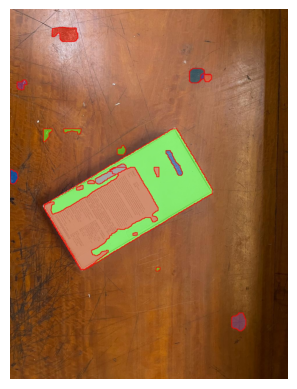

In [12]:

# TIME THIS CELL
# everything prompt
ann_everything = fast_sam_prompt_process.everything_prompt()

fast_sam_prompt_process.plot(annotations=ann_everything,output_path='./output/box_everything.jpg',)

# show output image
output_image = cv2.imread("output/box_everything.jpg")
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image_rgb)
plt.axis('off')  # optional: to hide the axis
plt.show()

In [13]:
fast_sam_predictor

[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes', 'masks']
 masks: ultralytics.yolo.engine.results.Masks object
 names: {0: 'object'}
 orig_img: array([[[195, 128,  99],
         [194, 129,  99],
         [195, 130, 102],
         ...,
         [ 84,  41,   0],
         [ 84,  41,   0],
         [ 85,  42,   0]],
 
        [[190, 123,  94],
         [191, 126,  96],
         [193, 129, 101],
         ...,
         [ 84,  41,   0],
         [ 86,  43,   1],
         [ 89,  46,   4]],
 
        [[182, 117,  89],
         [186, 121,  93],
         [190, 126,  98],
         ...,
         [ 83,  40,   0],
         [ 88,  45,   3],
         [ 92,  49,   7]],
 
        ...,
 
        [[123,  65,  17],
         [124,  66,  18],
         [126,  68,  20],
         ...,
         [ 53,  21,   0],
         [ 53,  21,   0],
         [ 53,  21,   0]],
 
        [[124,  66,  18],
         [125,  67,

### Point Prompt

In [14]:
fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)
ann_center_point = fast_sam_prompt_process.point_prompt(
    points=input_point, pointlabel=input_label
)

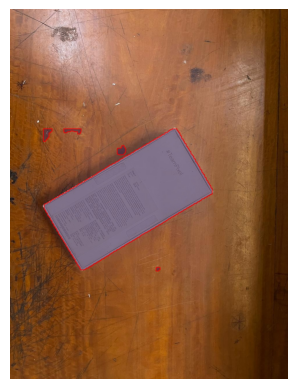

In [15]:


fast_sam_prompt_process.plot(annotations=ann_center_point,output_path='./output/box_center_point.jpg',)

# show output image
output_image = cv2.imread("output/box_center_point.jpg")
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image_rgb)
plt.axis('off')  # optional: to hide the axis
plt.show()

### Binary Mask Generation

In [16]:
ann_everything.shape

torch.Size([11, 1280, 960])

In [17]:
ann_center_point.shape

(1, 1280, 960)

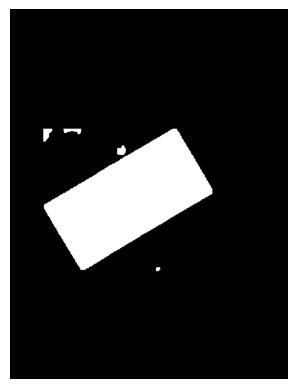

True

In [18]:
ann_center_point_squeezed = np.squeeze(ann_center_point) # remove the first dimension

# Convert boolean array to binary image
binary_mask_center_point = ann_center_point_squeezed.astype(np.uint8) * 255

# show binary mask
plt.imshow(binary_mask_center_point, cmap='gray')
plt.axis('off')  # optional: to hide the axis
plt.show()

# save image as "binary_mask.jpg"
cv2.imwrite("output/binary_mask_center_point.jpg", binary_mask_center_point)

### Filter only the rectangle

In [19]:
import cv2
import numpy as np

# Load the binary image
image = cv2.imread('output/binary_mask_center_point.jpg', cv2.IMREAD_GRAYSCALE)

# Find contours
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [20]:
len(contours)

211

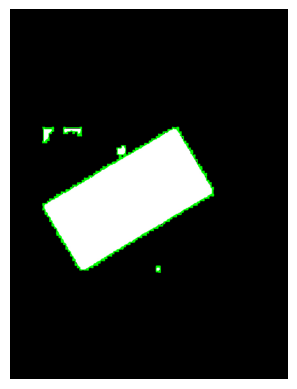

True

In [21]:

# Convert grayscale image to BGR (so you can draw the contours in color)
image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw the contours in green
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

# Plot the image with contours using matplotlib
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')  # optional: to hide the axis
plt.show()

# save image with contours as "image_with_contours.jpg"
cv2.imwrite("output/image_with_contours_center_point.jpg", cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))

### Draw boxes around every contour

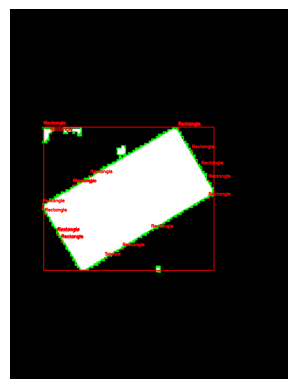

In [22]:
# Perplexity of the image
for cnt in contours:
    # Approximate the contour
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    
    # Check if the approximated contour has 4 points
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        
        # Classify as rectangle or square based on aspect ratio
        if 0.9 <= aspect_ratio <= 1.1:
            label = "Square"
        else:
            label = "Rectangle"
        
        # Draw the rectangle and label
        cv2.rectangle(image_with_contours, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(image_with_contours, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,255), 2)
        
# Plot the image with rectangles and labels using matplotlib
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')  # optional: to hide the axis
plt.show()

### Draw boxes around the biggest rectangular contour

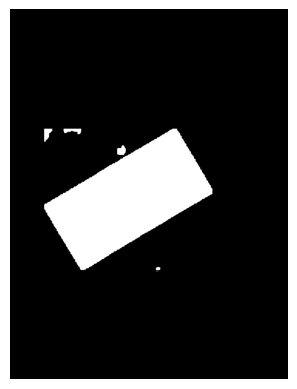

True

In [23]:
# Load the binary image
image = cv2.imread('output/binary_mask_center_point.jpg', cv2.IMREAD_GRAYSCALE)

# Find contours
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_area = 0
largest_rectangle = None

for cnt in contours:
    # Approximate the contour
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    
    # Check if the approximated contour has 4 points
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        area = w * h  # Calculate the area of the rectangle
        
        # Update the largest rectangle if the current one is larger
        if area > largest_area:
            largest_area = area
            largest_rectangle = (x, y, w, h, approx)

# Draw the largest rectangle if found
if largest_rectangle is not None:
    x, y, w, h, approx = largest_rectangle
    aspect_ratio = float(w) / h
    
    # Classify as rectangle or square based on aspect ratio
    if 0.9 <= aspect_ratio <= 1.1:
        label = "Square"
    else:
        label = "Rectangle"
    
    # Draw the largest rectangle and label
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Plot the image with the largest rectangle and label using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Optional: to hide the axis
plt.show()

# save image
cv2.imwrite("output/binary_mask.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Claude 3.5 

In [38]:
image.shape

(1280, 960)

(1280, 960)


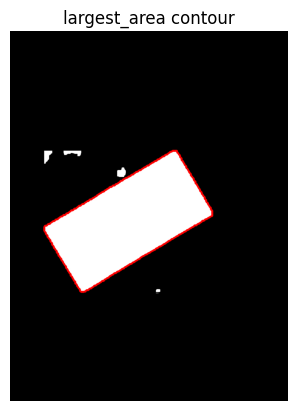

True

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('output/binary_mask.jpg', 0)  # Read as grayscale
print(image.shape)
# Threshold the image
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Create a copy of the original image for drawing
result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw the largest contour
cv2.drawContours(result, [largest_contour], 0, (0, 0, 255), 5)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("largest_area contour")
plt.show()

# Save the image with the largest contour
cv2.imwrite('output/largest_contour.jpg', result)

(1280, 960)


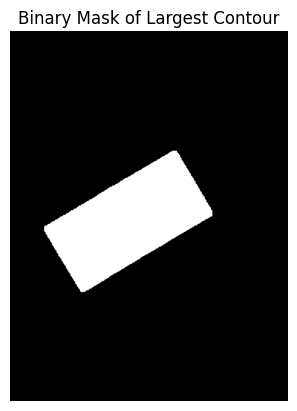

True

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('output/binary_mask.jpg', 0)  # Read as grayscale
print(image.shape)

# Threshold the image
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Create an empty mask with the same dimensions as the input image
new_mask = np.zeros_like(image)

# Draw the largest contour on the mask and fill it
cv2.drawContours(new_mask, [largest_contour], 0, (255), thickness=cv2.FILLED)

# Display the new binary mask
plt.imshow(new_mask, cmap='gray')
plt.axis('off')
plt.title("Binary Mask of Largest Contour")
plt.show()

# Save the binary mask image
cv2.imwrite('output/largest_contour_mask.jpg', new_mask)


In [25]:
largest_contour

array([[[561, 414]],

       [[558, 417]],

       [[555, 417]],

       ...,

       [[577, 418]],

       [[576, 417]],

       [[576, 414]]], dtype=int32)

### Correct implementation

Top-most point: (561, 414)
right_most point: (698, 639)
Bottom-most point: (245, 902)
Left-most point: (118, 677)


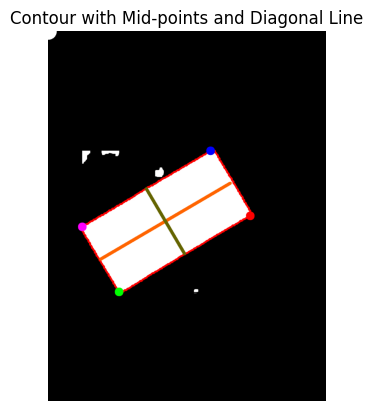

In [26]:
import numpy as np

# Assuming largest_contour is your contour array with shape (767, 1, 2)

# Reshape the contour to remove the extra dimension
contour_points = largest_contour.reshape(-1, 2)

# Get the top-most point (minimum y)
top_most = tuple(contour_points[contour_points[:, 1].argmin()])
bottom_most = tuple(contour_points[contour_points[:, 1].argmax()])

# Get the left-most point (minimum x)
left_most = tuple(contour_points[contour_points[:, 0].argmin()])
right_most = tuple(contour_points[contour_points[:, 0].argmax()])

(x1, y1) = left_most
(x2, y2) = top_most 
(x3, y3) = right_most
(x4, y4) = bottom_most

print(f"Top-most point: {top_most}")
print(f"right_most point: {right_most}")
print(f"Bottom-most point: {bottom_most}")
print(f"Left-most point: {left_most}")

# If you want to visualize these points on your image:
cv2.circle(result, top_most, 15, (255, 0, 0), -1)  # Blue circle for top-most
cv2.circle(result, right_most, 15, (0, 0, 255), -1)  # Red circle for right-most
cv2.circle(result, bottom_most, 15, (0, 255, 0), -1)  # Green circle for bottom-most
cv2.circle(result, left_most, 15, (255, 0, 255), -1)  # Yellow circle for left-most

cv2.circle(result, (0,0), 30, (255, 255, 255), -1)  # White circle for origin

A = (int((x1 + x4) / 2), int((y1 + y4) / 2)) # Mid point between left-most and bottom-most
B = (int((x2 + x3) / 2), int((y2 + y3) / 2)) # Mid point between top-most and right-most

C = (int((x1 + x2) / 2), int((y1 + y2) / 2)) # Mid point between left-most and top-most
D = (int((x3 + x4) / 2), int((y3 + y4) / 2)) # Mid point between right-most and bottom-most

# Draw a line between A & B
cv2.line(result, A, B, (0, 100, 255), 10)
cv2.line(result, C, D, (0, 100, 100), 10)

# Display the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Contour with Mid-points and Diagonal Line')
plt.axis('off')
plt.show()

In [27]:
camera_frame_center = (int(img_width / 2), int(img_height / 2))

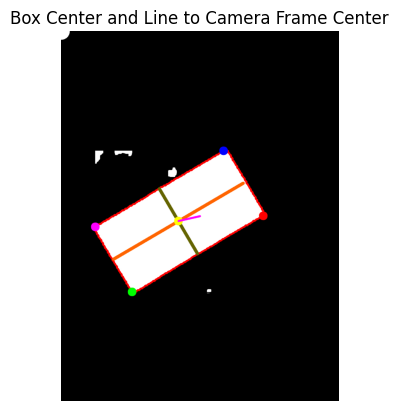

In [28]:
# box center is midpoint of AB line
box_center = (int((A[0] + B[0]) / 2), int((A[1] + B[1]) / 2))

# plot the box center on the image
result_with_box_center = result.copy()
cv2.circle(result_with_box_center, box_center, 15, (0, 255, 255), -1)  # Cyan circle for box center

# Draw a line between camera frame center and box center
cv2.line(result_with_box_center, camera_frame_center, box_center, (255, 0, 255), 5)

# Display the result
plt.imshow(cv2.cvtColor(result_with_box_center, cv2.COLOR_BGR2RGB))
plt.title('Box Center and Line to Camera Frame Center')
plt.axis('off')
plt.show()

In [29]:
type(left_most)

tuple

In [30]:
print(x1)

118


In [31]:
# AB : Length of the line between A & B
AB = ((B[1] - A[1])**2 + (B[0] - A[0])**2)**0.5
CD = ((D[1] - C[1])**2 + (D[0] - C[0])**2)**0.5

In [32]:
AB

519.4930220898063

In [33]:
A

(181, 789)

In [34]:
B

(629, 526)

In [35]:
# if AB >= CD : longer_side = AB, shorter_side = CD
# orientation_angle is tan_inverse(AB)in degrees
if AB >= CD:
  orientation_angle = np.arctan2((abs(B[1] - A[1])), (B[0] - A[0])) * 180 / np.pi
  print("AB >= CD")
elif CD > AB:
  orientation_angle = np.arctan2((D[1] - C[1]), (D[0] - C[0])) * 180 / np.pi
  print("AB < CD")

orientation_angle

AB >= CD


30.41521680282955

**Problem TODO** : Now there are points in the contour with respect to the rectangle which are right most but not the corners. 

**TODO** : Write a formula to get the lines from the points and then get the intersection points. and plot diagronal lines. 

In [36]:
largest_contour.shape

(754, 1, 2)

### Erraneous output (discard this- This is not what I want, previous implementation would give these yellow lines)

Top-left: (118, 414)
Top-right: (699, 414)
Bottom-left: (118, 903)
Bottom-right: (699, 903)


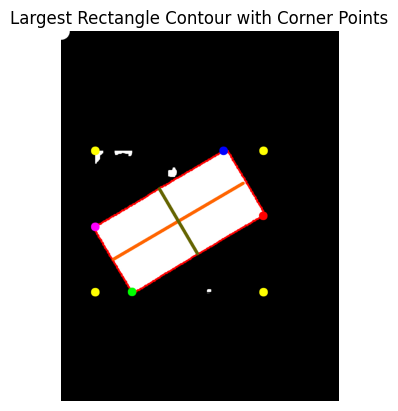

In [37]:
# Get the bounding rectangle
x, y, w, h = cv2.boundingRect(largest_contour)

# Get edge coordinates
top_left = (x, y)
top_right = (x + w, y)
bottom_left = (x, y + h)
bottom_right = (x + w, y + h)

# Print edge coordinates
print(f"Top-left: {top_left}")
print(f"Top-right: {top_right}")
print(f"Bottom-left: {bottom_left}")
print(f"Bottom-right: {bottom_right}")

# Draw red circles at the corners
for corner in [top_left, top_right, bottom_left, bottom_right]:
    cv2.circle(result, corner, 15, (0, 255, 255), -1)

# Display the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Largest Rectangle Contour with Corner Points')
plt.axis('off')
plt.show()

This is erraneous output. I want to get the corners of the contour. So have to discard this

TODO : 
1. Increase the exposure if there's no box detected (Look into Gamma transform)

# VS Code extensions
1. RUFF 


2. Try to identify all the boxes